In [185]:
import numpy as np
import coffea
from coffea.nanoaod import NanoEvents
from coffea import processor, hist
%matplotlib inline
import matplotlib.pyplot as plt

In [25]:
fname = "/Users/herwig/Desktop/dominic/data/met100_skim.root"
events = NanoEvents.from_file(fname)

Can directly get the objects and check their properties

In [184]:
# truth collections
truth_n2 = events.GenPart[
    (events.GenPart.pdgId == 1000023)
    & events.GenPart.hasFlags(['isLastCopy'])
]
truth_n1 = events.GenPart[
    (events.GenPart.pdgId == 1000022)
    & (events.GenPart.parent.pdgId == 1000023)
    & events.GenPart.hasFlags(['isLastCopy'])
]
truth_eles = events.GenPart[
    (abs(events.GenPart.pdgId) == 11)
    & events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
]
dM = truth_n2.mass-truth_n1.mass
mask = truth_eles.counts==2
ee_events = truth_eles[mask]
dM = dM[mask]
ee=ee_events[:,0]+ee_events[:,1]
ee.mass [ (dM<2)[:,0] ]


/Users/herwig/miniconda3/envs/coffea/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


array([0.7674082 , 0.8898775 , 0.64670414, ..., 0.8615264 , 0.6542648 ,
       0.46107867], dtype=float32)

Do the full analysis in a processor

In [187]:
class TruthAna(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "N2-N1 mass difference")
        mass_axis = hist.Bin("mass", r"$m_{ee}$ [GeV]", 40, 0, 4)
        pt_axis = hist.Bin("pt", r"$p_{T,e}$ [GeV]", 40, 0, 8)
        lead_pt_axis = hist.Bin("pt", r"$p_{T,e1}$ [GeV]", 40, 0, 8)
        sub_pt_axis = hist.Bin("pt", r"$p_{T,e2}$ [GeV]", 40, 0, 4)

        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("Counts", dataset_axis, mass_axis),
            'pt_all': hist.Hist("Counts", dataset_axis, pt_axis),
            'pt_lead': hist.Hist("Counts", dataset_axis, lead_pt_axis),
            'pt_sub': hist.Hist("Counts", dataset_axis, sub_pt_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        
        truth_n2 = events.GenPart[ (events.GenPart.pdgId == 1000023)
            & events.GenPart.hasFlags(['isLastCopy'])]
        truth_n1 = events.GenPart[(events.GenPart.pdgId == 1000022)
            & (events.GenPart.parent.pdgId == 1000023)
            & events.GenPart.hasFlags(['isLastCopy'])]
        truth_eles = events.GenPart[(abs(events.GenPart.pdgId) == 11)
            & events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])]
        # calc dM
        dM = truth_n2.mass-truth_n1.mass
        # get ee events
        mask = (truth_eles.counts==2)
        
        dM = dM[mask]
        ee_events = truth_eles[mask]
        ee = ee_events[:,0]+ee_events[:,1]
        lead = ee_events[ee_events.pt.argmax()]
        sublead = ee_events[ee_events.pt.argmin()]
        
        isDM1 = (dM<2)[:,0]
        subsets={'dM1': isDM1,'dM3': ~isDM1}
        for tag, rule in subsets.items():
            out["mass"].fill(
                dataset=tag, #events.metadata["dataset"],
                mass=ee[rule].mass.flatten(),
            )
            out["pt_lead"].fill(dataset=tag, pt=lead[rule].pt.flatten())
            out["pt_sub"].fill(dataset=tag, pt=sublead[rule].pt.flatten())
        return out

    def postprocess(self, accumulator):
        return accumulator

In [188]:
samples = { "N2N1": [fname] }

result = processor.run_uproot_job(
    samples,
    "Events",
    TruthAna(),
    processor.iterative_executor,
    {"nano": True},
)

/Users/herwig/miniconda3/envs/coffea/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


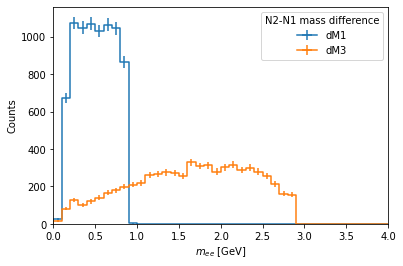

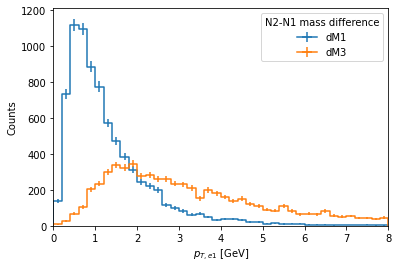

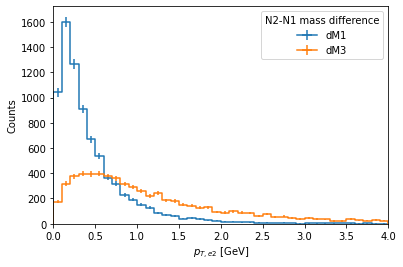

In [189]:
plt.figure()
hist.plot1d(result["mass"])
plt.figure()
hist.plot1d(result["pt_lead"])
plt.figure()
hist.plot1d(result["pt_sub"])

Now try things with the reco objects

In [ ]:
events.ElectronBPark[events.ElectronBPark.genPartIdx >=0]